Epoch 001 | train MSE = 2.925100e-02
Epoch 005 | train MSE = 9.674036e-04
Epoch 010 | train MSE = 4.090772e-04
Epoch 015 | train MSE = 2.298062e-04
Epoch 020 | train MSE = 2.231087e-04
Epoch 025 | train MSE = 1.307633e-04
Epoch 030 | train MSE = 1.075015e-04
Epoch 035 | train MSE = 1.302465e-04
Epoch 040 | train MSE = 1.336642e-04
Epoch 045 | train MSE = 1.542834e-04
Epoch 050 | train MSE = 8.455755e-05
Epoch 055 | train MSE = 1.171831e-04
Epoch 060 | train MSE = 7.824057e-05


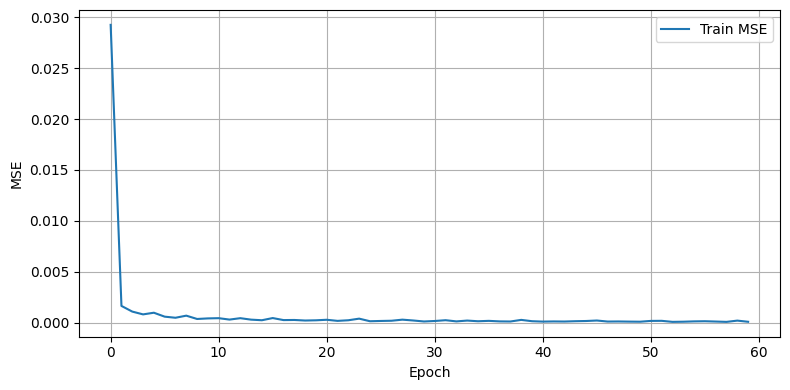

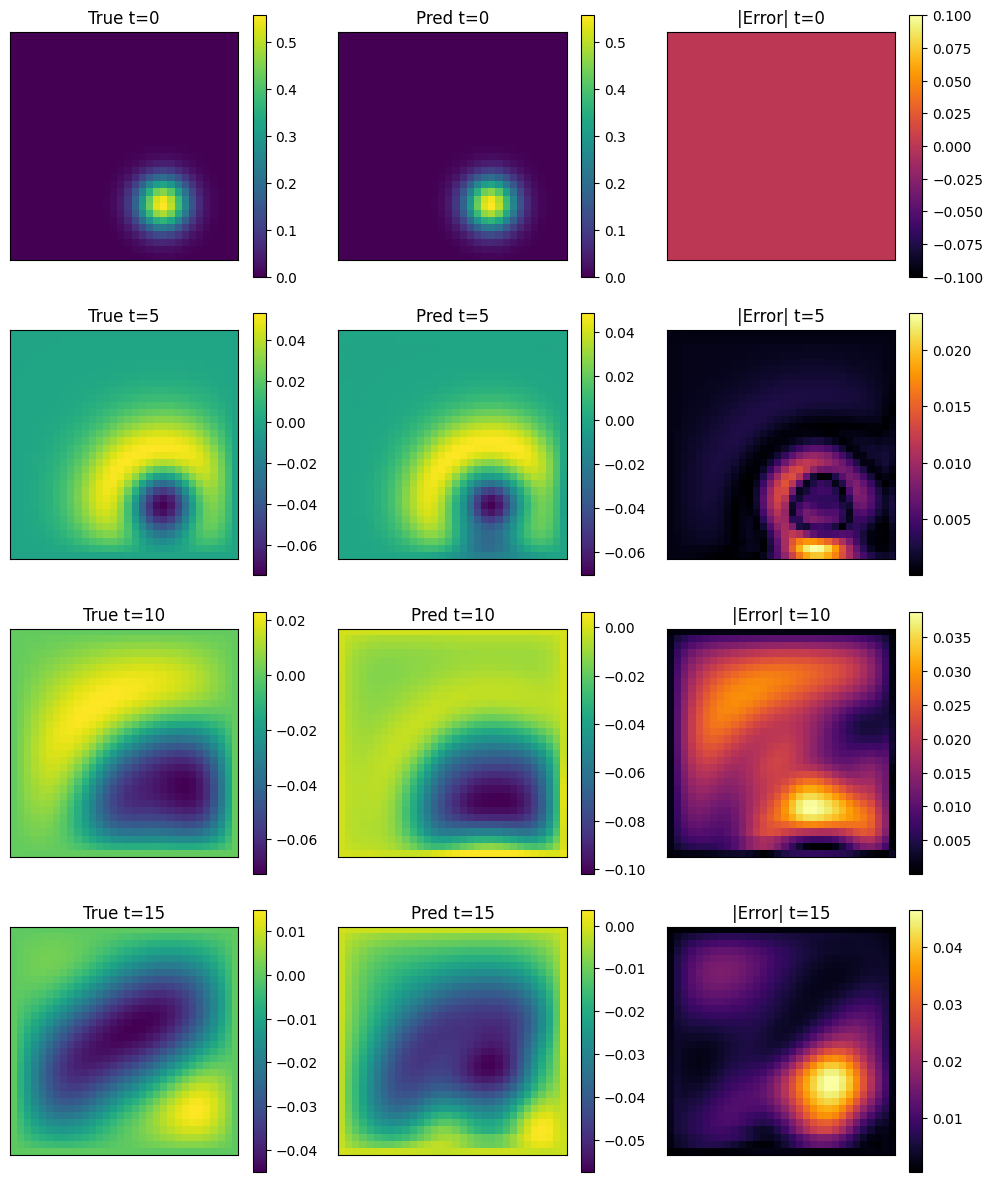

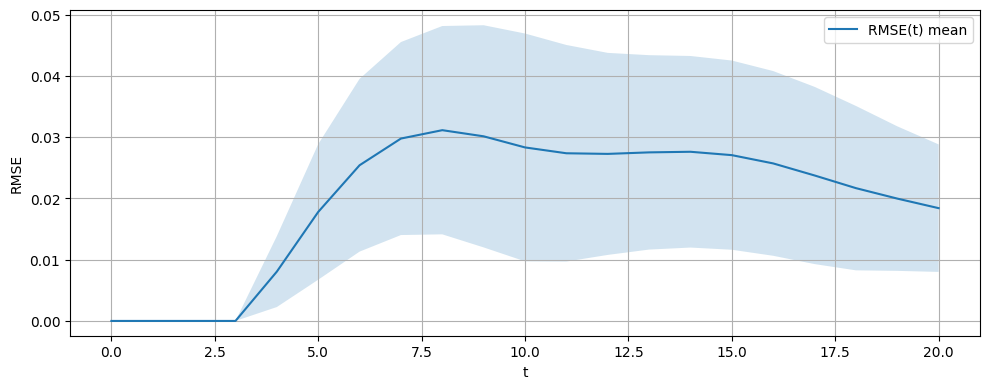

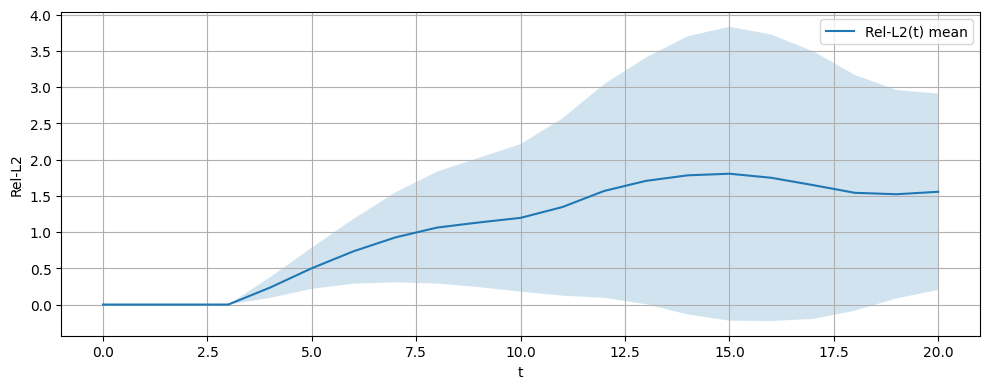

Overall RMSE (mean over B×T): 1.9862e-02
Overall Rel-L2 (mean over B×T): 1.0482e+00


In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ----------------------------
# Dataset: windowed stepper
# ----------------------------
class WindowedStepperDataset(Dataset):
    """
    Build windows of length L ending at time t, predicting u^{t+1}.
    Expects npz with u:(B,T+1,H,W), f:(B,T+1,H,W), layout THW per sample.
    """
    def __init__(self, npz_path, L=4, normalize=True, stats=None):
        data = np.load(npz_path)
        self.u = data["u"]      # (B, T+1, H, W)
        self.f = data["f"]      # (B, T+1, H, W)
        self.B, self.T1, self.H, self.W = self.u.shape
        self.L = L
        self.normalize = normalize
        
        T = self.T1 - 1
        self.indices = [(b, t) for b in range(self.B) for t in range(L, T)]

        if normalize and stats is None:
            u_mean, u_std = self.u.mean(), self.u.std() + 1e-6
            f_mean, f_std = self.f.mean(), self.f.std() + 1e-6
            self.X_mean = np.array([u_mean, u_mean, f_mean], dtype=np.float32).reshape(1, 3, 1, 1)
            self.X_std  = np.array([u_std,  u_std,  f_std ], dtype=np.float32).reshape(1, 3, 1, 1)
            self.Y_mean = float(u_mean); self.Y_std = float(u_std)
        elif normalize and stats is not None:
            self.X_mean = stats["X_mean"].numpy()
            self.X_std  = stats["X_std"].numpy()
            self.Y_mean = float(stats["Y_mean"])
            self.Y_std  = float(stats["Y_std"])
        else:
            self.X_mean = self.X_std = self.Y_mean = self.Y_std = None

    def __len__(self): return len(self.indices)

    def __getitem__(self, idx):
        b, t = self.indices[idx]
        # Build L steps: for k=0..L-1, we need (u^{tau-1}, u^{tau}, f^{tau}) with tau = t-L+1+k
        frames = []
        for k in range(self.L):
            tau = t - (self.L - 1) + k            # tau goes ... t-1, t
            frames.append(np.stack([
                self.u[b, tau-1],                # u^{tau-1}
                self.u[b, tau],                  # u^{tau}
                self.f[b, tau]                   # f^{tau}
            ], axis=0))                           # (3,H,W)
        X = np.stack(frames, axis=0)              # (L,3,H,W)
        Y = self.u[b, t+1]                        # (H,W)

        if self.normalize:
            X = (X - self.X_mean) / self.X_std
            Y = (Y - self.Y_mean) / self.Y_std

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

    @property
    def stats(self):
        if not self.normalize:
            return None
        return {
            "X_mean": torch.tensor(self.X_mean),
            "X_std":  torch.tensor(self.X_std),
            "Y_mean": torch.tensor(self.Y_mean),
            "Y_std":  torch.tensor(self.Y_std),
        }

# ----------------------------
# Mamba stepper model
# ----------------------------
from mamba_ssm import Mamba

class MambaBlock(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.mamba = Mamba(d_model=d_model)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):                 # (B*H*W, L, d)
        h = self.mamba(self.norm(x))
        return x + self.drop(h)           # residual

def sinusoidal_time_emb(L, d, device):
    pe = torch.zeros(L, d, device=device)
    pos = torch.arange(L, device=device).unsqueeze(1)
    div = torch.exp(torch.arange(0, d, 2, device=device) * (-math.log(10000.0) / d))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe

class SpatialEncoder(nn.Module):
    def __init__(self, in_ch=3, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, hidden, 3, padding=1), nn.GELU(),
            nn.Conv2d(hidden, hidden, 3, padding=1), nn.GELU()
        )
    def forward(self, x):  # (B*L,3,H,W)
        return self.net(x) # (B*L,d,H,W)

class MambaStepper(nn.Module):
    """
    Input:  (B, L, 3, H, W)  → predicts u^{t+1} (B,H,W)
    """
    def __init__(self, hidden=64, n_layers=4, dropout=0.1):
        super().__init__()
        self.enc = SpatialEncoder(in_ch=3, hidden=hidden)
        self.temporal = nn.Sequential(*[MambaBlock(hidden, dropout) for _ in range(n_layers)])
        self.head = nn.Linear(hidden, 1)

    def forward(self, x):                 # x: (B,L,3,H,W)
        B, L, C, H, W = x.shape
        z = x.reshape(B*L, C, H, W)
        z = self.enc(z)                   # (B*L,d,H,W)
        d = z.shape[1]
        z = z.reshape(B, L, d, H, W)      # (B,L,d,H,W)

        z = z.permute(0, 3, 4, 1, 2).contiguous()  # (B,H,W,L,d)
        z = z.view(B*H*W, L, d)                    # (B*H*W,L,d)

        # Time embedding
        pe = sinusoidal_time_emb(L, d, device=z.device)  # (L,d)
        z = z + pe.unsqueeze(0)

        # Mamba temporal mixing
        z = self.temporal(z)               # (B*H*W,L,d)
        z_last = z[:, -1, :]               # (B*H*W,d)

        y = self.head(z_last).squeeze(-1)  # (B*H*W,)
        y = y.view(B, H, W)
        return y

# ----------------------------
# Training loop
# ----------------------------
def train_mamba_stepper(train_npz, L=4, hidden=64, n_layers=4, dropout=0.1,
                        epochs=60, batch_size=16, lr=3e-4, wd=1e-4, device=None):
    device = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))

    ds = WindowedStepperDataset(train_npz, L=L, normalize=True)
    stats = ds.stats
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0)

    model = MambaStepper(hidden=hidden, n_layers=n_layers, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    train_losses = []
    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        for X, Y in dl:
            X, Y = X.to(device), Y.to(device)
            opt.zero_grad()
            Yhat = model(X)
            loss = F.mse_loss(Yhat, Y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            running += loss.item()
        running /= len(dl)
        train_losses.append(running)
        if ep % 5 == 0 or ep == 1:
            print(f"Epoch {ep:03d} | train MSE = {running:.6e}")

    # plot loss
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label="Train MSE")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    return model, stats

# ----------------------------
# Rollout (single sample)
# ----------------------------
@torch.no_grad()
def rollout_with_window(model, stats, u_seq_true, f_seq, L=4, warmup=1, device=None):
    """
    Autoregressive rollout, building a window of length L at each step.
    u_seq_true, f_seq: (T+1,H,W)
    Returns: u_pred (T+1,H,W), rmse_t (T+1,), rel_l2_t (T+1,)
    """
    device = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))
    model.eval()

    X_mean = stats["X_mean"].to(device)   # (1,3,1,1)
    X_std  = stats["X_std"].to(device)
    Y_mean = float(stats["Y_mean"])
    Y_std  = float(stats["Y_std"])

    T1, H, W = u_seq_true.shape
    T = T1 - 1
    u_pred = np.zeros_like(u_seq_true)
    u_pred[0] = u_seq_true[0]

    # warmup: copy true frames for t=1..warmup
    for t in range(1, min(warmup, T)+1):
        u_pred[t] = u_seq_true[t]

    # start predicting from n = max(warmup, L) to T-1
    n_start = max(warmup, L-1)
    for t in range(1, n_start+1):
        if u_pred[t].sum() == 0:
            u_pred[t] = u_seq_true[t]

    for n in range(n_start, T):
        # Build a window ending at n: we need times [n-L+1 .. n]
        frames = []
        for k in range(L):
            tau = n - (L - 1) + k
            frames.append(np.stack([u_pred[tau-1], u_pred[tau], f_seq[tau]], axis=0))
        X = np.stack(frames, axis=0)  # (L,3,H,W)

        X_t = torch.from_numpy(X).float().unsqueeze(0).to(device)  # (1,L,3,H,W)
        X_t = (X_t - X_mean) / X_std

        Yhat_norm = model(X_t).squeeze(0).cpu().numpy()   # (H,W) normalized
        Yhat = Yhat_norm * Y_std + Y_mean
        u_pred[n+1] = Yhat

    # metrics
    rmse_t = np.zeros(T1); rel_l2_t = np.zeros(T1)
    for t in range(T1):
        err = u_pred[t] - u_seq_true[t]
        rmse_t[t] = np.sqrt(np.mean(err**2))
        denom = np.linalg.norm(u_seq_true[t].ravel()) + 1e-12
        rel_l2_t[t] = np.linalg.norm(err.ravel()) / denom
    return u_pred, rmse_t, rel_l2_t

def plot_rollout_curves(all_rmse, all_rel):
    T1 = all_rmse.shape[1]
    t = np.arange(T1)
    plt.figure(figsize=(10,4))
    plt.plot(t, all_rmse.mean(0), label="RMSE(t) mean"); 
    plt.fill_between(t, all_rmse.mean(0)-all_rmse.std(0), all_rmse.mean(0)+all_rmse.std(0), alpha=0.2)
    plt.xlabel("t"); plt.ylabel("RMSE"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(t, all_rel.mean(0), label="Rel-L2(t) mean"); 
    plt.fill_between(t, all_rel.mean(0)-all_rel.std(0), all_rel.mean(0)+all_rel.std(0), alpha=0.2)
    plt.xlabel("t"); plt.ylabel("Rel-L2"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

def show_frames(u_true, u_pred, times=(0,5,10,15)):
    fig, axs = plt.subplots(len(times), 3, figsize=(10, 3*len(times)))
    for row, t in enumerate(times):
        im0 = axs[row,0].imshow(u_true[t], origin="lower", cmap="viridis"); axs[row,0].set_title(f"True t={t}"); plt.colorbar(im0, ax=axs[row,0])
        im1 = axs[row,1].imshow(u_pred[t], origin="lower", cmap="viridis"); axs[row,1].set_title(f"Pred t={t}"); plt.colorbar(im1, ax=axs[row,1])
        err = np.abs(u_true[t]-u_pred[t]); im2 = axs[row,2].imshow(err, origin="lower", cmap="inferno"); axs[row,2].set_title(f"|Error| t={t}"); plt.colorbar(im2, ax=axs[row,2])
        for j in range(3): axs[row,j].set_xticks([]); axs[row,j].set_yticks([])
    plt.tight_layout(); plt.show()

# ----------------------------
# MAIN
# ----------------------------

train_npz = "train_wave_stepper.npz"
test_npz  = "test_wave_stepper.npz"

# Train
model, stats = train_mamba_stepper(train_npz,
                                    L=4, hidden=64, n_layers=4, dropout=0.1,
                                    epochs=60, batch_size=16, lr=3e-4, wd=1e-4)

# Save model + stats
torch.save({"model_state": model.state_dict(),
            "stats": {k: v.cpu() for k, v in stats.items()},
            "config": {"L": 4, "hidden": 64, "n_layers": 4, "dropout": 0.1}},
            "mamba_stepper.pt")

# Rollout on test set
data = np.load(test_npz)
u_test = data["u"]   # (B,T+1,H,W)
f_test = data["f"]
B = u_test.shape[0]

all_rmse, all_rel = [], []
for i in range(B):
    u_pred, rmse_t, rel_t = rollout_with_window(model, stats, u_test[i], f_test[i],
                                                L=4, warmup=1)
    all_rmse.append(rmse_t); all_rel.append(rel_t)
    if i == 0:
        show_frames(u_test[i], u_pred, times=[0, 5, 10, 15])

all_rmse = np.stack(all_rmse, axis=0)   # (B,T+1)
all_rel  = np.stack(all_rel, axis=0)
plot_rollout_curves(all_rmse, all_rel)

print(f"Overall RMSE (mean over B×T): {all_rmse.mean():.4e}")
print(f"Overall Rel-L2 (mean over B×T): {all_rel.mean():.4e}")